In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from pixell import curvedsky
from pixell import powspec
from pixell import utils, sharp, enmap
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from pixell import enplot

In [4]:
fname = "data/new_ethos_a4_scalCls.dat"
CMB, lensing = powspec.read_camb_scalar(fname)

In [5]:
shape=(2,1000,1000)
wcs = curvedsky.wcsutils.build( pos=(0.0,0.0), res=2. / 60, system="CAR")
test_map = curvedsky.rand_map(shape,  wcs, CMB[1:,1:,:], lmax=5000, spin=2)

In [6]:
tmap, mslices, tslices = curvedsky.make_projectable_map_cyl(test_map)

In [7]:
tmap[:] = 0
for mslice, tslice in zip(mslices, tslices):
    tmap[tslice] = test_map[mslice]
minfo = curvedsky.match_predefined_minfo(tmap, None, None)

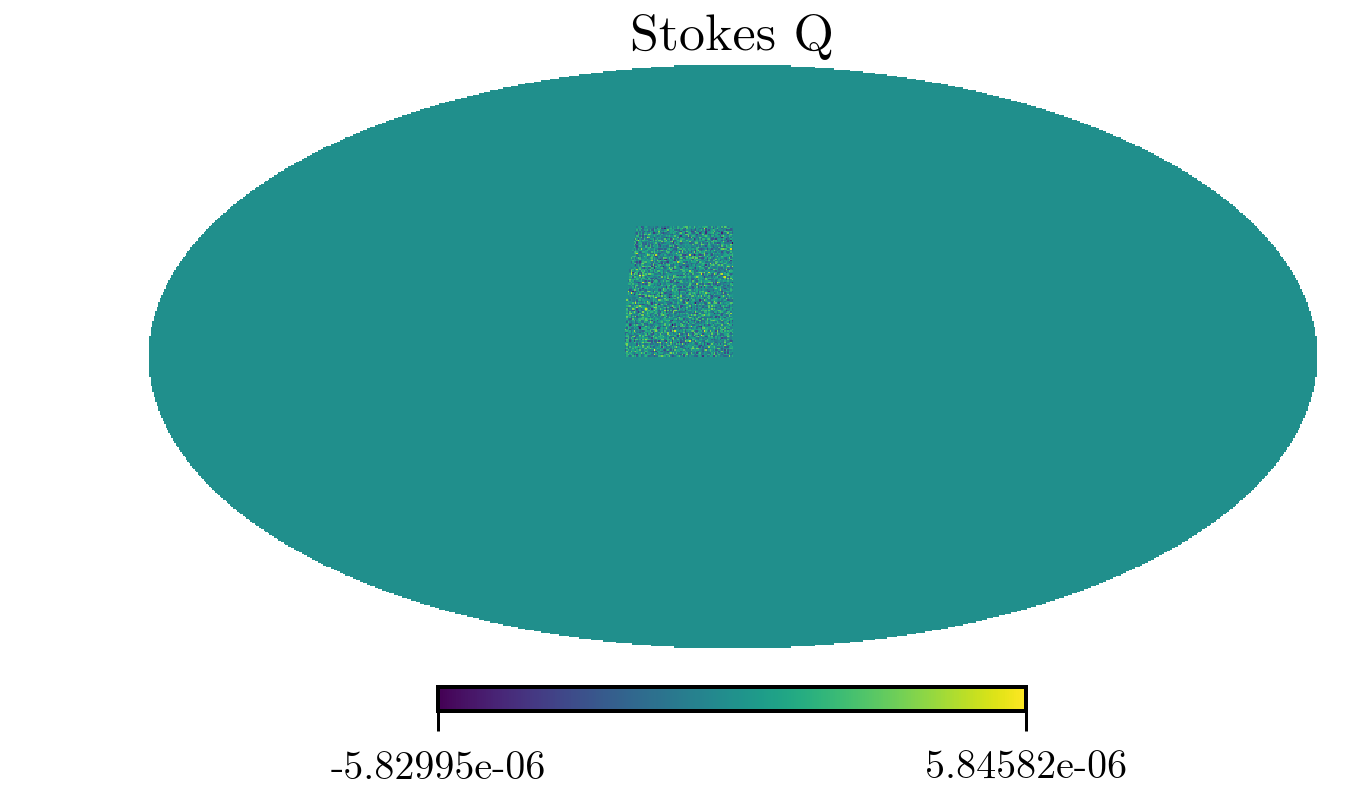

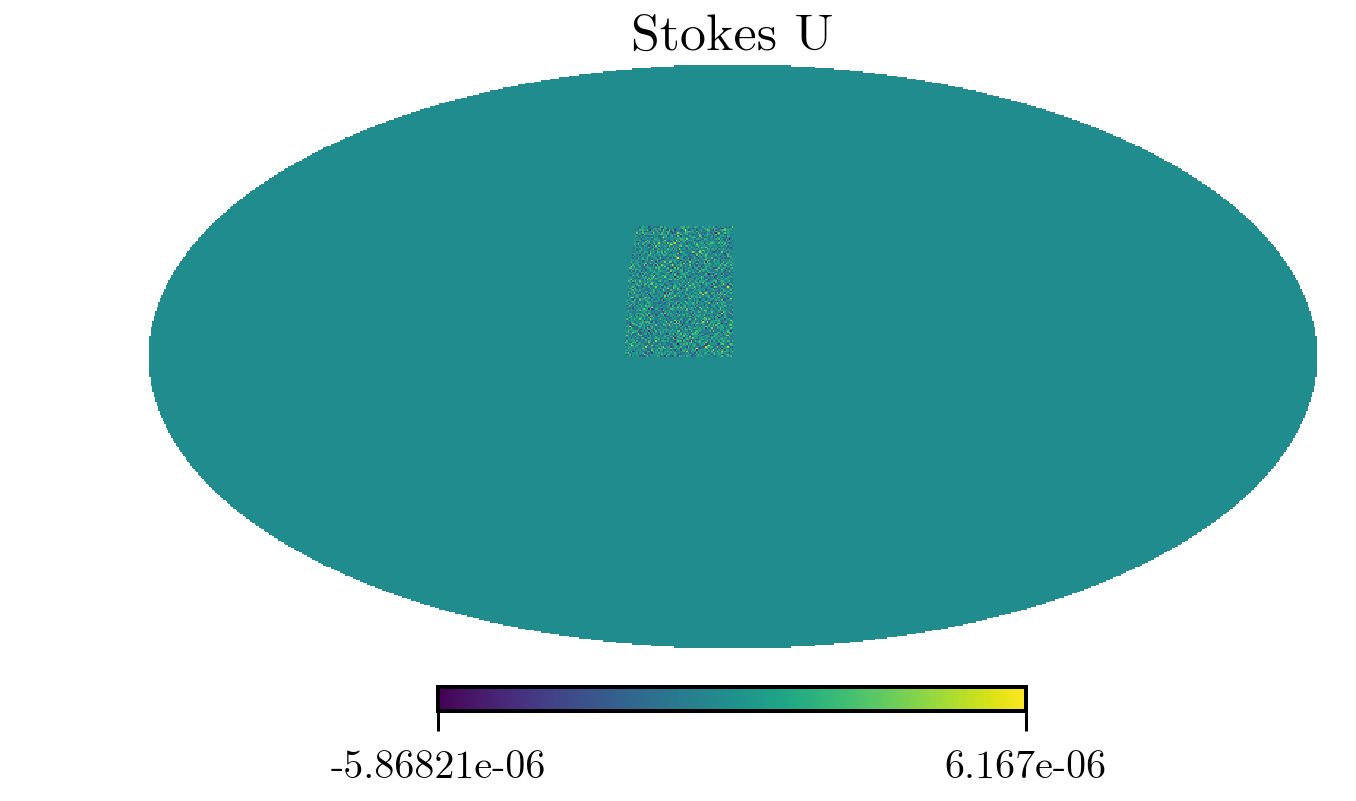

In [10]:
nside = 512
import healpy as hp
hp.mollview( enmap.to_healpix(tmap[0,:,:], nside=nside),  title="Stokes Q")
hp.mollview( enmap.to_healpix(tmap[1,:,:], nside=nside),  title="Stokes U")

In [11]:
enmap.write_map("pol_car.fits", tmap)
heal_map = enmap.to_healpix(tmap, nside=nside)
hp.write_map("pol_heal.fits", heal_map, overwrite=True)

mask = test_map[:]
mask = mask * 0 + 1
tmask, mslices, tslices = curvedsky.make_projectable_map_cyl(mask)
tmask[:] = 0
for mslice, tslice in zip(mslices, tslices):
    tmask[tslice] = mask[mslice]

enmap.write_map("pol_carmask.fits", tmask)
hp.write_map("pol_healmask.fits", enmap.to_healpix(tmask[0,:,:], nside=nside), overwrite=True)

# Analysis

Now one runs the program in `ACT_test.c`, which generates `sample_out.txt` and `sample_output_heal.txt`. 

It's important to note that **the CAR map must be a full ring, i.e. full longitude.**. I've done that in the cell above by padding the missing pixels.

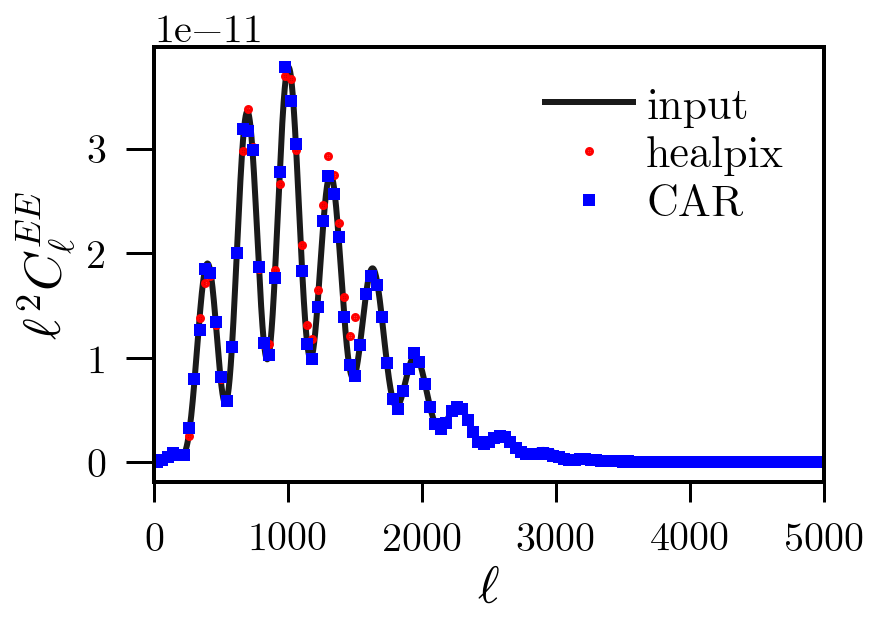

In [15]:
from astropy.io import ascii

data2 = ascii.read("out.txt")
plt.plot(np.arange(5501), np.arange(5501)**2 * CMB[1,1,:], label="input")

data1 = ascii.read("../out.txt")  
plt.plot(data1['col1'], data1['col1']**2 * data1['col2'], "r.", label="healpix", lw = 3)
plt.plot(data2['col1'], data2['col1']**2 * data2['col2'], "bs", lw=2, label="CAR")

plt.xlim(0,5000)
# plt.yscale("log")
plt.ylabel(r"$\ell^2 C_{\ell}^{EE}$")
plt.xlabel(r"$\ell$")

plt.legend()

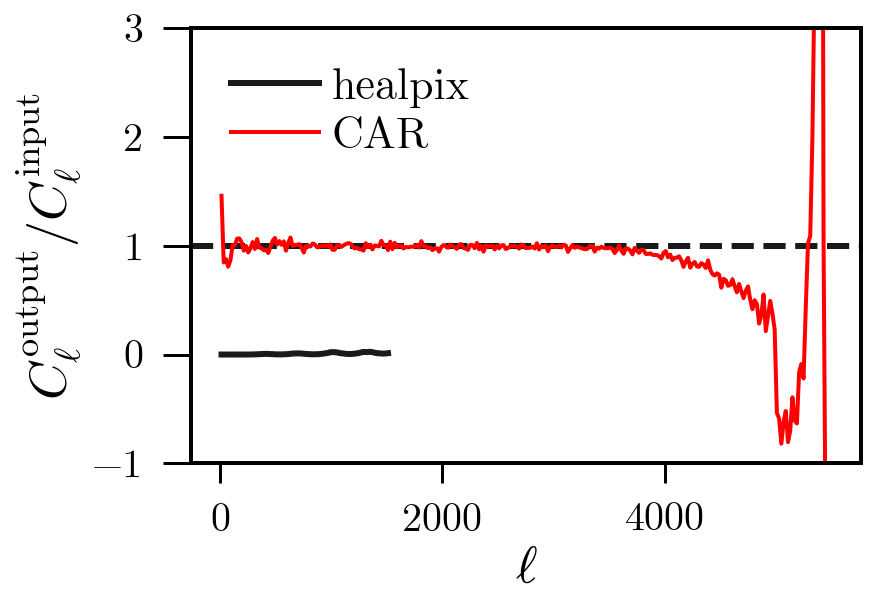

In [92]:

data1 = ascii.read("sample_output_heal.txt")  
data1 = data1[data1['col1'] < 5500]
data2 = ascii.read("sample_output.txt")
data2 = data2[data2['col1'] < 5500]
# plt.plot(np.arange(5501), np.arange(5501)**4 * CMB[0,0,:])

plt.axhline(1, ls="dashed")
plt.plot(data1['col1'], data1['col2'] / CMB[0,0,:][data1['col1'].astype(int)], label="healpix", lw = 3)
plt.plot(data2['col1'], data2['col2'] / CMB[0,0,:][data2['col1'].astype(int)], lw=2, label="CAR", color="red", ls="solid")
plt.ylim(-1,3)

plt.ylabel(r"$C_{\ell}^{\mathrm{output}} / C_{\ell}^{\mathrm{input}}$")
plt.xlabel(r"$\ell$")
plt.legend()